# Callin Switzer
___

### 16 Jan 2020
### - Train without pruning
### - Then prune


___

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rc('font',family='Times New Roman')
from matplotlib.ticker import ScalarFormatter
import os
import pandas as pd
import time
from datetime import datetime
import sys
import seaborn as sns
import scipy.io
import subprocess
import winsound
import pickle
import glob
import sqlite3

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
print("TensorFlow successfully installed.")
if tf.test.is_built_with_cuda():
    print("The installed version of TensorFlow includes GPU support.")
print(sys.version, "\n")
now = datetime.now()
print("last run on " + str(now))

# define directories
baseDir = os.getcwd()
dataDir = r'D:\MothSimulations\11c-AggressiveManeuver\Qstore\hws_am_con'
figDir = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\Figs'
dataOutput = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\DataOutput'
savedModels = r'D:\Dropbox\AcademiaDropbox\mothMachineLearning_dataAndFigs\savedModels'
dataDir = r'D:/Dropbox/AcademiaDropbox/mothMachineLearning_dataAndFigs/PythonGeneratedData_oneTorque/'
if not os.path.exists(figDir):
    os.mkdir(figDir)

if not os.path.exists(dataOutput):
    os.mkdir(dataOutput)
if not os.path.exists(savedModels):
    os.mkdir(savedModels)


TensorFlow successfully installed.
The installed version of TensorFlow includes GPU support.
3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)] 

last run on 2020-01-29 15:20:30.541733


In [2]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

Using TensorFlow backend.


# Make training and test set

In [3]:
# get table names in database
con1 = sqlite3.connect(os.path.join(dataDir, "oneTorqueData.db"))
cursorObj = con1.cursor()
res = cursorObj.execute("SELECT name FROM sqlite_master WHERE type='table';")
tableNames = [name[0] for name in res]
con1.close()
print(tableNames)

['test', 'train']


In [4]:
con1 = sqlite3.connect(os.path.join(dataDir, "oneTorqueData.db"))
trainDF = pd.read_sql_query("SELECT * FROM train", con1)
testDF = pd.read_sql_query("SELECT * FROM test", con1)
con1.close()

In [5]:
# double check for repeats!
np.sum(trainDF.iloc[:, [16,17,18]].duplicated()) # 0 means no repeats

0

In [6]:
print(trainDF.shape)
trainDF.head()

(10000000, 19)


,x_0,xd_0,y_0,yd_0,theta_0,thetad_0,phi_0,phid_0,x_f,xd_f,y_f,yd_f,theta_f,thetad_f,phi_f,phid_f,F,alpha,tau0
0,0.0,1127.569064,0.0,765.895323,1.075898,11.962440,3.427385,18.462602,18.323331,716.627905,14.965420,553.784155,2.653195,147.068401,5.115222,153.187791,41181.992912,1.987846,-63216.237665
1,0.0,979.651081,0.0,-625.561275,0.306688,-5.637037,2.576453,19.788635,18.603118,878.261004,-13.758388,-732.267264,0.102441,-34.254744,2.372751,-34.214230,9062.020340,3.567122,19108.940596
2,0.0,1111.257777,0.0,-1406.672066,5.094943,16.102668,1.775724,-9.188076,19.014000,1058.629029,-25.108839,-1007.321715,2.811424,-218.672246,-0.370204,-211.787743,42727.993224,4.104033,49781.327507
3,0.0,-1438.730397,0.0,690.882986,5.034187,-3.375327,5.534301,-9.669100,-31.101504,-1501.738112,10.625933,331.290367,6.319507,141.205184,6.795796,140.443097,28953.145279,4.698031,92261.347215
4,0.0,1370.322727,0.0,-216.459775,4.186927,-16.500337,3.194818,-0.385905,27.276171,1358.779274,-4.544002,-238.613391,3.984840,-10.035763,3.181642,-0.756667,371.601599,0.668810,-40259.257246


In [7]:
# rename columns to be consistent with other code
trainDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

# rename columns to be consistent with other code
testDF.rename(columns={"x0" : "x_0", "y0" : "y_0", "phi0" : "phi_0", "theta0" : "theta_0", 
                        "x_f" : "x_99", "y_f" : "y_99", "phi_f" : "phi_99", "theta_f" : "theta_99", 
                        "xd_0" : "x_dot_0", "yd_0" : "y_dot_0", "phid_0" : "phi_dot_0", "thetad_0": "theta_dot_0", 
                        "xd_f" : "x_dot_99", "yd_f": "y_dot_99", "phid_f": "phi_dot_99", "thetad_f": "theta_dot_99", 
                        "tau0" : "tau"}, inplace=True)

In [8]:
# convert to fx and fy
trainDF["Fx"] = trainDF.F * np.cos(trainDF.alpha)
trainDF["Fy"] = trainDF.F * np.sin(trainDF.alpha)

testDF["Fx"] = testDF.F * np.cos(testDF.alpha)
testDF["Fy"] = testDF.F * np.sin(testDF.alpha)


In [9]:
# make dataset
X = trainDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Y = trainDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

# make test dataset
Xtest = testDF.loc[:, [ "phi_0", "theta_0", 
                    "x_99", "y_99", "phi_99", "theta_99", 
                   "x_dot_0", "y_dot_0", "phi_dot_0", "theta_dot_0"]]

Ytest = testDF.loc[:, ["Fx", "Fy", "tau", "x_dot_99", "y_dot_99", 
                    "phi_dot_99", "theta_dot_99"] ]

In [10]:
X.head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,3.427385,1.075898,18.323331,14.965420,5.115222,2.653195,1127.569064,765.895323,18.462602,11.962440
1,2.576453,0.306688,18.603118,-13.758388,2.372751,0.102441,979.651081,-625.561275,19.788635,-5.637037
2,1.775724,5.094943,19.014000,-25.108839,-0.370204,2.811424,1111.257777,-1406.672066,-9.188076,16.102668
3,5.534301,5.034187,-31.101504,10.625933,6.795796,6.319507,-1438.730397,690.882986,-9.669100,-3.375327
4,3.194818,4.186927,27.276171,-4.544002,3.181642,3.984840,1370.322727,-216.459775,-0.385905,-16.500337


In [11]:
Y.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99
0,-16681.383440,37652.197635,-63216.237665,716.627905,553.784155,153.187791,147.068401
1,-8253.874132,-3740.825371,19108.940596,878.261004,-732.267264,-34.214230,-34.254744
2,-24419.876370,-35062.102662,49781.327507,1058.629029,-1007.321715,-211.787743,-218.672246
3,-415.702991,-28950.160838,92261.347215,-1501.738112,331.290367,140.443097,141.205184
4,291.543841,230.412537,-40259.257246,1358.779274,-238.613391,-0.756667,-10.035763


In [12]:
# val train split
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size=0.2, random_state = 123)

In [13]:
# scale data 
scalerX = MinMaxScaler([-0.5, 0.5])  
scalerY = MinMaxScaler([-0.5, 0.5])  

# Don't cheat - fit only on training data
scalerX.fit(Xtrain)  
scalerY.fit(Ytrain) 

Xtrain_scaled = scalerX.transform(Xtrain)  
Ytrain_scaled = scalerY.transform(Ytrain)  

# apply same transformation to test data
Xval_scaled = scalerX.transform(Xval)
Yval_scaled = scalerY.transform(Yval)


# final test data
Xtest_scaled = scalerX.transform(Xtest)

In [14]:
pd.DataFrame(Xtrain_scaled, columns = X.columns).head()

,phi_0,theta_0,x_99,y_99,phi_99,theta_99,x_dot_0,y_dot_0,phi_dot_0,theta_dot_0
0,0.440808,-0.497541,-0.376881,-0.092528,0.279106,-0.125546,-0.413733,-0.087276,0.151751,-0.419563
1,0.002656,0.450960,0.232234,0.301146,-0.030380,0.180345,0.276074,0.383212,0.227138,0.094672
2,0.302116,0.217276,0.364791,-0.175444,-0.008066,-0.047502,0.385703,-0.188919,-0.266187,-0.202705
3,-0.471247,0.121804,0.070077,0.310735,-0.319397,-0.062783,0.103501,0.332100,-0.227711,0.447327
4,-0.350056,-0.349031,0.313582,0.159721,-0.093290,-0.092005,0.350805,0.216431,0.136925,0.270457


# Keras models

In [15]:
# import
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras import regularizers

# Keras callcacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

K.clear_session()

In [16]:
# create network
def create_network(optimizer = 'rmsprop', 
                    numUnits = [400, 16], 
                    weightRegularization = 0.0, 
                    dropout_rate=0.1):
    
    '''
    Create a feed forward network.  Assumes Xtrain & Ytrain have been created and scaled
    
    Params: 
    optimizer (str): choice of optimizer
    numUnits (list): number of units in each hidden
    weightRegularization (float): between 0 and 1
    dropout_rate (float): between 0 and 1
    
    '''
    K.clear_session()
    inputs = Input(shape=(Xtrain_scaled.shape[1],))    
    
    # add layers
    for ii in np.arange(0, len(numUnits)):
        if ii >= 1: 
            x = Dense(numUnits[ii], activation='tanh', 
                      kernel_regularizer=regularizers.l1(weightRegularization))(x)

        else: 
            x = Dense(numUnits[ii], activation='tanh')(inputs)


        # add dropout
        if dropout_rate > 0: 
            x = Dropout(dropout_rate)(x)
    
    predictions = Dense(Ytrain_scaled.shape[1], activation='linear')(x)

    # create model
    model = Model(inputs=inputs, outputs=predictions)
    model.compile(loss="mean_squared_error", optimizer = optimizer, metrics = ['mse'])

    return(model)

In [17]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]


earlystop = EarlyStopping(monitor='val_mean_squared_error', patience=150, 
                          verbose=1, mode='auto', min_delta = 0.000001)

In [18]:
def plot_model_history(model_history, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history.history['mean_squared_error'])+1),
             model_history.history['mean_squared_error'])
    axs.plot(range(1,len(model_history.history['val_mean_squared_error'])+1),
             model_history.history['val_mean_squared_error'])
    axs.set_title('Model MSE = '+ str(format_e(model_history.history['val_mean_squared_error'][-1])))
    axs.set_ylabel('Mean squared error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(0,len(model_history.history['val_mean_squared_error']), 50), 50)
    axs.legend(['train', 'validation'], loc='best')
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + ".pdf"), dpi = 500, bbox_inches='tight')
    
    plt.show()

    
def plot_model_history_fromDict(model_history_dictionary, saveFig = False):
    fig, axs = plt.subplots(1,1,figsize=(10,5))
    # summarize history for accuracy
    axs.plot(range(1,len(model_history_dictionary['mean_squared_error'])+1),
             model_history_dictionary['mean_squared_error'])
    axs.plot(range(1,len(model_history_dictionary['val_mean_squared_error'])+1),
             model_history_dictionary['val_mean_squared_error'], alpha = 0.7)
    axs.set_title('Model MSE = '+ str(format_e(model_history_dictionary['val_mean_squared_error'][-1])))
    axs.set_ylabel('Mean squared error')
    axs.set_xlabel('Epoch')
    axs.set_xticks(np.arange(0,len(model_history_dictionary['val_mean_squared_error']), 50),50)
    axs.legend(['train', 'validation'], loc=2)
    plt.yscale('log') #logarithmic scale for y axis
    if saveFig:
        fig.savefig(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"), dpi = 120, bbox_inches='tight')
        print(os.path.join(figDir, "ModelTraining_" + modelName + "_pruned.png"))


___

In [19]:
# train and trim weights

In [20]:

K.clear_session()

modelParams = {"optimizer": "rmsprop", 
              "dropout_rate" : 0, 
               "numUnits": [400, 400, 400, 16],
               "weightRegularization": 0
              }


model = create_network(**modelParams)

modeltimestamp = datetime.now().strftime("%Y_%m_%d__%I_%M_%S")
modelName = ''.join('{}_{}__'.format(key[0:3].capitalize(), val) for  key, val in modelParams.items()).\
                            replace("[", "").replace("]", "").replace(", ", "_")[0:-2] + "_" + modeltimestamp
print(modelName)

model.summary()

Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_01_29__03_23_38
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               4400      
_________________________________________________________________
dense_2 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 400)               160400    
_________________________________________________________________
dense_4 (Dense)              (None, 16)                6416      
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 119       
Total params: 331,735
Trainable params: 331,735
Non-trainable params: 0
___

In [21]:
# # save scalers, to be used on test set
scalerfileX = 'scalerX_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerX, open(os.path.join(dataOutput, scalerfileX), 'wb'))

scalerfileY = 'scalerY_fullact_' + modeltimestamp + '.pkl'
pickle.dump(scalerY, open(os.path.join(dataOutput, scalerfileY), 'wb'))

In [22]:
# start training
historyDict = {"mean_squared_error": [], 
               "val_mean_squared_error": []}

In [65]:
# train without pruning
history = model.fit(Xtrain_scaled, Ytrain_scaled, 
                    validation_data=(Xval_scaled, Yval_scaled), 
                    callbacks = [earlystop],
                    verbose = 2, batch_size=2**12, epochs = 1000)

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1000
 - 17s - loss: 8.9093e-04 - mean_squared_error: 8.9093e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 2/1000


KeyboardInterrupt: 

In [24]:
# save history
historyDict["mean_squared_error"].extend(history.history["mean_squared_error"])
historyDict["val_mean_squared_error"].extend(history.history["val_mean_squared_error"])

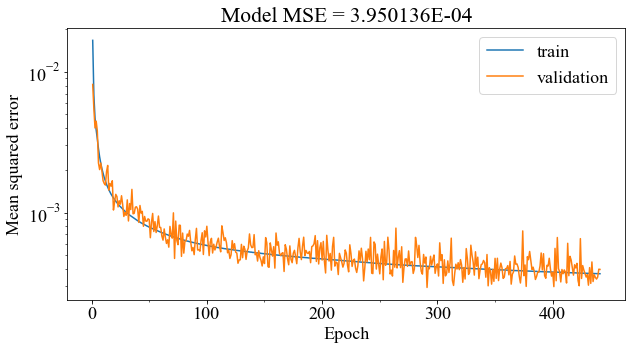

In [46]:
plot_model_history_fromDict(historyDict)

In [27]:
# save model
model.save(os.path.join(savedModels,  modelName + '.h5'))

# save weights
wts = model.get_weights().copy()

wtsFile = modelName + '_wts.pkl'
pickle.dump(wts, open(os.path.join(dataOutput, wtsFile), 'wb'))

# save history with same name as model
historyFile = modeltimestamp + '_history.pkl'
pickle.dump(historyDict, open(os.path.join(dataOutput, historyFile), 'wb'))

In [ ]:
#  plot error rates on test data

In [28]:
# predict on test set
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(Ytest, columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()


,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,Fx_pred,Fy_pred,tau_pred,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred
0,-5342.432439,14670.842555,-57718.558932,-577.070011,-1317.410003,-76.817401,-84.515766,-7392.211914,14465.547852,-59310.175781,-663.213379,-1354.858154,-82.408806,-91.926399
1,-2515.747661,3418.036434,-64775.342625,-18.839022,1292.672193,17.808851,1.199298,-2983.888672,4440.507812,-66103.882812,32.584209,1239.415527,16.307154,0.870372
2,-6497.950980,-17669.503572,-49237.798014,-1094.713883,-1469.532303,124.939700,115.462788,-9890.788086,-18193.863281,-58011.730469,-1055.526611,-1523.011230,124.054146,114.269966
3,24237.433019,-8489.629561,56490.932254,-187.441953,-427.573908,100.329900,100.827942,23219.056641,-9776.681641,58684.093750,-223.637711,-549.093811,101.455544,103.454163
4,1782.839206,5791.542006,26503.920442,625.069923,31.217768,-26.216617,-20.827598,2032.573486,3798.215820,26243.095703,575.248596,11.581472,-16.173641,-13.360766


In [29]:
#df_c = df_c.iloc[:1000, :]

# df_c = df_c.replace([np.inf, -np.inf], np.nan)
# df_c = df_c.replace([np.inf, -np.inf], np.nan).dropna()

In [30]:
import matplotlib.ticker as mtick
import matplotlib
class MathTextSciFormatter(mtick.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            return(" ")
        return "${}$".format(s)

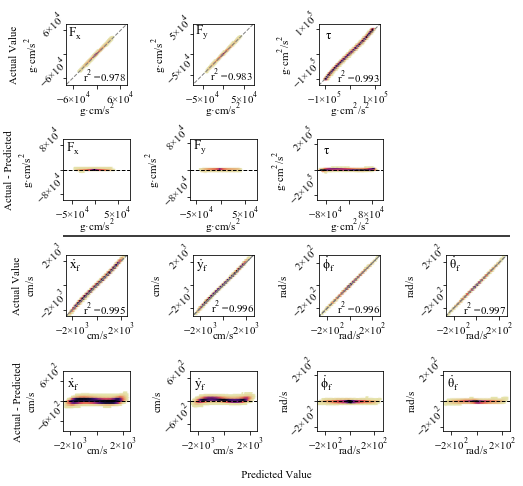

In [36]:
# make plots
from sklearn.metrics import r2_score
from matplotlib import ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 11})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.transforms as mtrans


fig_col_names = [r'$F_x$', r'$F_y$', r'$\tau$', r'$\dot{x}_f$', r'$\dot{y}_f$', r'$\dot{\phi}_f$', r'$\dot{\theta}_f$']

plt.close("all")
fig, axs = plt.subplots(4,4, figsize=np.array([8, 7.5]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.9, wspace=.9)
# fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r'$g·cm/s^2$', "$g·cm/s^2$", "$g·cm^2/s^2$", "$cm/s$", "$cm/s$", "$rad/s$", "$rad/s$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
# make really low-value hexbins white
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, 3):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].set_yticklabels(axs[ii].get_yticklabels(), 
                            rotation = 45, ha="center",
                            va = "bottom", rotation_mode="anchor")
    axs[ii].yaxis.set_label_coords(-0.4,0.5)
    axs[ii].set_xlabel(ylabs[ii] + "\n")
    axs[ii].xaxis.set_label_coords(0.5,-0.2)
    axs[ii].tick_params(axis="x",direction="out", pad=-0)
    

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].set_title(fig_col_names[ii], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[ii].title
    ttl.set_position([.15, 0.62])
    
    # draw identity lines
    lims = [
        np.min([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # min of both axes
        np.max([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # max of both axes
        ]
    axs[ii].plot(lims, lims,  
                 'grey', linewidth = 1, linestyle  = "--")
#     axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
#                  df_c.loc[:,YtestDF.columns[ii]], 
#                  'grey', linewidth = 1, linestyle  = "--")
    axs[ii].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].set_aspect('equal', 'box')

    # annotate with R^2
    axs[ii].text(np.max(lims)*-0.4, 
                 np.min(lims)*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])
    axs[ii].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(4, 7)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.2)
    
    if jj == 3:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                      Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])
        
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.62])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
#####
#### Part 2
#####

#fig.subplots_adjust(hspace = 0.9, wspace=.9)

# Plot y = actual, x = predicted
for plotnum, dataColNum in zip(np.arange(8,12), np.arange(3, 7)):
    axs[plotnum].hexbin(y = df_c.loc[:,YtestDF.columns[dataColNum]],
                   x = df_c.loc[:,YpredDF.columns[dataColNum]], 
                   gridsize = 50, cmap = cmap)
    axs[plotnum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].set_yticklabels(axs[plotnum].get_yticklabels(),
                                 rotation = 45, ha="center",
                                 va = "bottom", rotation_mode="anchor")
    axs[plotnum].yaxis.set_label_coords(-0.5,0.5)
    axs[plotnum].set_xlabel(ylabs[dataColNum] + "\n")
    axs[plotnum].xaxis.set_label_coords(0.5,-0.2)

    if(plotnum == 8):
        axs[plotnum].set_ylabel("Actual Value\n" + ylabs[dataColNum])
    else:
        axs[plotnum].set_ylabel(ylabs[dataColNum])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[plotnum].set_title(fig_col_names[dataColNum], 
                           fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotnum].title
    ttl.set_position([.15, 0.60])
    axs[plotnum].plot(df_c.loc[:,YtestDF.columns[dataColNum]], 
                 df_c.loc[:,YtestDF.columns[dataColNum]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[plotnum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].set_aspect('equal', 'box')

    # annotate with R^2
    axs[plotnum].text(np.max(df_c.loc[:,YtestDF.columns[dataColNum]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[dataColNum]])*0.85, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[dataColNum]],  
                                        df_c.loc[:,YpredDF.columns[dataColNum]])), 3)))
    axs[plotnum].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    axs[plotnum].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    
    axs[plotnum].tick_params(axis="x",direction="out", pad=-0)

# residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
# refref Here
for jj, plotNum in zip(np.arange(3, 7), np.arange(12, 16)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.2)
    
    if jj == 4:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                                       Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 3):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.55])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
    
axs[3].axis('off')
axs[7].axis('off')

# add black horizontal line
ax3 = plt.figure(1).add_subplot(111)
ax3.plot([-1,1],[0.48,0.48], '-', color = "black" )
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.axis("off")

#plt.tight_layout()
#fig.savefig(os.path.join(figDir, "PredVActual" + modelName + ".pdf"),)
plt.show()
# plt.close()

In [66]:
## Pruning
modelName

'Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_01_27__01_30_06'

In [101]:
# load model
from keras.models import load_model

K.clear_session()


modelName =  "Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_01_27__01_30_06"
modeltimestamp = "2020_01_27__01_30_06"
model = load_model(os.path.join(savedModels,  modelName + ".h5"))

# load weights
wtsFile = modelName + '_wts.pkl'
wts = pickle.load(open(os.path.join(dataOutput, wtsFile), 'rb'))

# load history with same name as model
historyFile = modeltimestamp + '_history.pkl'
historyDict = pickle.load(open(os.path.join(dataOutput, historyFile), 'rb'))


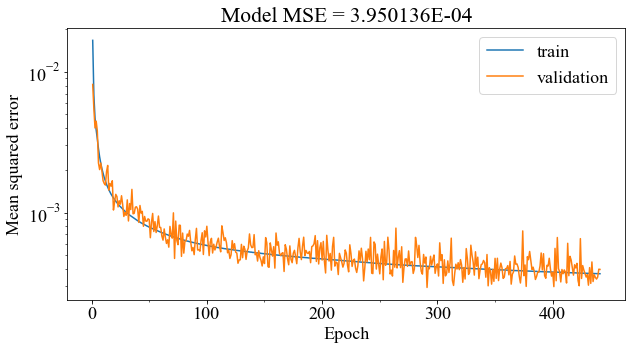

In [102]:
plt.rcParams.update({'font.size': 18})
plot_model_history_fromDict(historyDict)

In [111]:
# train with pruning
numCuts = 1

wts = model.get_weights()
wtLengths = []
for ii in range(len(wts)):
    wtLengths.append(np.prod(wts[ii].shape))

In [112]:


# make new folder to save each prune
modelSubdir = os.path.join(savedModels, modeltimestamp + "_checkpoints")
if not os.path.exists(modelSubdir):
    os.mkdir(modelSubdir)

In [251]:
# train until I have very good results
# then prune, and retrain until results are close
# change pruning rate as data get closer to 100% removed
def prune_percent_updater(x):
    logit = np.exp(x*8) / (np.exp(x*8) + 1)
    return((logit - 0.5)*2*50)

# cuts a smaller portion as the percent gets closer to 100%
cutPercent = prune_percent_updater(np.linspace(0, 1, 26))

print(cutPercent*2)

[ 0.         15.86485043 30.95069212 44.62436102 56.48995528 66.40367703
 74.42768674 80.75689166 85.64849155 89.36977272 92.16685544 94.25030081
 95.7917306  96.92645889 97.75871874 98.36748577 98.81189556 99.1358533
 99.37175734 99.54340943 99.66823978 99.75898315 99.82492807 99.87284121
 99.90764768 99.93292997]


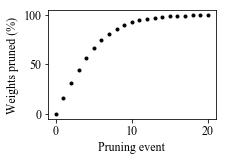

In [265]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=[3,2])
plt.plot((cutPercent*2)[0:21], ".", color = "black")
plt.xlabel("Pruning event")
plt.ylabel("Weights pruned (%)")
plt.savefig(os.path.join(figDir, "pruningPercentages.pdf"), bbox_inches='tight')

In [257]:
(cutPercent*2)[0:21]

array([ 0.        , 15.86485043, 30.95069212, 44.62436102, 56.48995528,
       66.40367703, 74.42768674, 80.75689166, 85.64849155, 89.36977272,
       92.16685544, 94.25030081, 95.7917306 , 96.92645889, 97.75871874,
       98.36748577, 98.81189556, 99.1358533 , 99.37175734, 99.54340943,
       99.66823978])

In [115]:
overallEpochCounter = len(historyDict['mean_squared_error'])
print(overallEpochCounter)

while True:   
   
    for numEpocs in range(100):
        
        MSE_tmp = []

        history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                            verbose = 2, batch_size=2**12, epochs = 1)
        
        overallEpochCounter += 1
        
        # save history
        historyDict["mean_squared_error"].append(history.history["mean_squared_error"][0])
        historyDict["val_mean_squared_error"].append(history.history["val_mean_squared_error"][0])
        
        # local MSE
        MSE_tmp.append(history.history["mean_squared_error"][0])

        # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
        # get nonzero weights
        wts = model.get_weights().copy()

        # set weights close to 0 to 0 (but ignore biases)
        for ii in np.arange(0, len(wts), 1):
            qants = np.percentile(np.reshape(wts[ii], -1), 
                                  q = (50 - cutPercent[numCuts], 
                                       50 + cutPercent[numCuts]), )
            wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

        # print nonzero weights
        # calculate number of nonzero weights
        nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
        print(nzwts, "of", np.sum(wtLengths), "weights retained")

        # set new weights and calculate new loss
        model.set_weights(wts)
        
        # check the change in mean squared error, and if it's not changing much, then cut out more data
        # calculate slope of loss, based on previous 5 data points
        if numEpocs > 5:
            inputData = historyDict["mean_squared_error"][-5:]

            m = np.shape(inputData)
            X = np.matrix([np.ones(m), np.arange(0, len(inputData))]).T
            y = np.matrix(np.log(inputData)).T

            # Solve for projection matrix
            intercept, slope = np.array(np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)).reshape(-1,)
            print("change in log loss:", slope)
    
            # break if slope has stopped changing or if the overall min has been surpassed
            # in the first training, it will automatically prune after 5 epochs, because the min will be passed
            if (np.abs(slope) < 0.0001) or (history.history["mean_squared_error"][0] < np.min(historyDict["mean_squared_error"][:-1])): 
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                print("************************************************ PRUNING ********************************************************")
                
                # save model
                model.save(os.path.join(savedModels,  modelSubdir, modelName + str(overallEpochCounter) + '_Pruned.h5'))
                
                
                # save weights
                wts = model.get_weights().copy()

                wtsFile = str(overallEpochCounter) + "_" + modelName + '_wts.pkl'
                pickle.dump(wts, open(os.path.join(savedModels, modelSubdir, wtsFile), 'wb'))

                # save history with same name as model
                historyFile = modeltimestamp + '_history.pkl'
                pickle.dump(historyDict, open(os.path.join(savedModels,modelSubdir, historyFile), 'wb'))
                
                numCuts += 1                
                break

    if numCuts >= len(cutPercent):
        break

        
        #cutPercent += 0.2
winsound.PlaySound("*", winsound.SND_ALIAS)

475
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 18s - loss: 3.6225e-04 - mean_squared_error: 3.6225e-04 - val_loss: 3.9478e-04 - val_mean_squared_error: 3.9478e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 18s - loss: 3.6239e-04 - mean_squared_error: 3.6239e-04 - val_loss: 3.1617e-04 - val_mean_squared_error: 3.1617e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 18s - loss: 3.6160e-04 - mean_squared_error: 3.6160e-04 - val_loss: 4.1755e-04 - val_mean_squared_error: 4.1755e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 18s - loss: 3.6196e-04 - mean_squared_error: 3.6196e-04 - val_loss: 4.8402e-04 - val_mean_squared_error: 4.8402e-04
279104 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 17s - loss: 3.6188e-04 - mean_squared_error: 3.6188e-04 - val

KeyboardInterrupt: 

In [295]:
1 - 279104 / 331735

0.15865374470586457

In [239]:
model.evaluate(Xval_scaled, Yval_scaled)

2000000/2000000 [==============================] - 52s 26us/step


[0.0014790439014490695, 0.0014790439014490695]

In [240]:
model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                            verbose = 2, batch_size=2**12, epochs = 1)

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 15s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0012 - val_mean_squared_error: 0.0012


In [241]:
model.evaluate(Xval_scaled, Yval_scaled)

2000000/2000000 [==============================] - 52s 26us/step


[0.001162542956698686, 0.001162542956698686]

In [242]:
model.evaluate(Xtrain_scaled, Ytrain_scaled)

8000000/8000000 [==============================] - 207s 26us/step


[0.001161295715918066, 0.001161295715918066]

In [243]:
wts = model.get_weights().copy()

# set weights close to 0 to 0 (but ignore biases)
for ii in np.arange(0, len(wts), 1):
    qants = np.percentile(np.reshape(wts[ii], -1), 
                          q = (50 - cutPercent[numCuts], 
                               50 + cutPercent[numCuts]), )
    wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

# print nonzero weights
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts, "of", np.sum(wtLengths), "weights retained")

# set new weights and calculate new loss
model.set_weights(wts)

1112 of 331735 weights retained


In [244]:
model.evaluate(Xtrain_scaled, Ytrain_scaled)

8000000/8000000 [==============================] - 205s 26us/step


[0.04451759360425919, 0.04451759360425919]

In [245]:
model.evaluate(Xval_scaled, Yval_scaled)

2000000/2000000 [==============================] - 51s 25us/step


[0.0445176967689395, 0.0445176967689395]

In [246]:
model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                            verbose = 2, batch_size=2**12, epochs = 1)

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 15s - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0011 - val_mean_squared_error: 0.0011


In [247]:
model.evaluate(Xtrain_scaled, Ytrain_scaled)

8000000/8000000 [==============================] - 205s 26us/step


[0.0010579734926895472, 0.0010579734926895472]

In [248]:
model.evaluate(Xval_scaled, Yval_scaled)

2000000/2000000 [==============================] - 51s 26us/step


[0.0010592131538907997, 0.0010592131538907997]

In [116]:
numCuts

20

In [197]:
str(np.round(cutPercent[19]*2, 2)) + "%"

'99.54%'

In [190]:
1 - (1526   / 331735) 

0.9953999427253681

In [289]:
# get cut points
savedChecks = [f for f in os.listdir(os.path.join(savedModels, modelSubdir)) if f.endswith('wts.pkl')]
vlines = [int(savedChecks[ii][0:4].replace("_", "")) for ii in range(len(savedChecks)) if savedChecks[ii][0].isdigit()]

In [290]:
len(vlines)

19

In [291]:
vlines.sort()
vlines.insert(0, 476) # this is the first cut  -- not saved
vlines

[476,
 484,
 491,
 498,
 505,
 512,
 535,
 572,
 642,
 704,
 839,
 907,
 1021,
 1042,
 1215,
 1278,
 1410,
 1484,
 1569,
 1683]

In [320]:
list(zip(vlines, [np.round(cutPercent[jj+1]*2, 2) for jj in  range(len(vlines))]))

[(476, 15.86),
 (484, 30.95),
 (491, 44.62),
 (498, 56.49),
 (505, 66.4),
 (512, 74.43),
 (535, 80.76),
 (572, 85.65),
 (642, 89.37),
 (704, 92.17),
 (839, 94.25),
 (907, 95.79),
 (1021, 96.93),
 (1042, 97.76),
 (1215, 98.37),
 (1278, 98.81),
 (1410, 99.14),
 (1484, 99.37),
 (1569, 99.54),
 (1683, 99.67)]

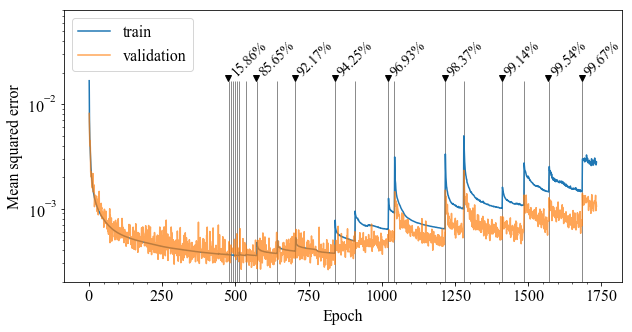

In [317]:
plt.rcParams.update({'font.size': 16})
plot_model_history_fromDict(historyDict)


for vline in vlines:
    plt.vlines(vline+1, ymin = 0, ymax = historyDict["mean_squared_error"][0], alpha = 0.5, linewidth = 0.9)

plt.ylim(10**-3.7, 10**-1.1)
plt.title("")

for jj in [0,7,9, 10,12, 14,16,18, 19]:
    s = str(np.round(cutPercent[jj+1]*2, 2)) + "%"
    plt.plot(vlines[jj], 10**-1.75, "v", color = "black")
    plt.text(vlines[jj], 10**-1.75, s,{'ha': 'left', 'va': 'bottom'}, fontsize=14, rotation=45)
plt.savefig(os.path.join(figDir, "ModelPruning_" + modelName + ".pdf"), bbox_inches='tight')
plt.show()

In [ ]:
## Reload model with 80% of connections pruned and evaluate error

In [355]:
K.clear_session()


modelName =  "Opt_rmsprop__Dro_0__Num_400_400_400_16__Wei_0_2020_01_27__01_30_06572_Pruned"
modeltimestamp = "2020_01_27__01_30_06"
model = load_model(os.path.join(savedModels, modelSubdir,  modelName + ".h5"))

In [360]:
wts = model.get_weights()
# print nonzero weights
# calculate number of nonzero weights
nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
print(nzwts, "of", np.sum(wtLengths), "weights retained")

63844 of 331735 weights retained


In [361]:
1 - nzwts / np.sum(wtLengths)

0.8075451791339473

In [362]:
numCuts = 7

cutPercent[numCuts]*2

80.75689165786144

In [367]:
for ii in range(10):
    history = model.fit(Xtrain_scaled, Ytrain_scaled, validation_data=(Xval_scaled, Yval_scaled), 
                        verbose = 2, batch_size=2**12, epochs = 1)

    # set weights that are close to 0 all the way back to 0, and then retrain for one epoch
    # get nonzero weights
    wts = model.get_weights().copy()

    # set weights close to 0 to 0 (but ignore biases)
    for ii in np.arange(0, len(wts), 1):
        qants = np.percentile(np.reshape(wts[ii], -1), 
                              q = (50 - cutPercent[numCuts], 
                                   50 + cutPercent[numCuts]), )
        wts[ii][(wts[ii] > qants[0]) & (wts[ii] < qants[1])] = 0

    # print nonzero weights
    # calculate number of nonzero weights
    nzwts = np.sum([np.nonzero(wts[ii].reshape(-1))[0].shape[0] for ii in range(len(wts))])
    print(nzwts, "of", np.sum(wtLengths), "weights retained")

    # set new weights and calculate new loss
    model.set_weights(wts)

Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 15s - loss: 3.5410e-04 - mean_squared_error: 3.5410e-04 - val_loss: 3.2232e-04 - val_mean_squared_error: 3.2232e-04
63844 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 15s - loss: 3.5416e-04 - mean_squared_error: 3.5416e-04 - val_loss: 3.7613e-04 - val_mean_squared_error: 3.7613e-04
63844 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 15s - loss: 3.5366e-04 - mean_squared_error: 3.5366e-04 - val_loss: 3.4420e-04 - val_mean_squared_error: 3.4420e-04
63844 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 15s - loss: 3.5422e-04 - mean_squared_error: 3.5422e-04 - val_loss: 2.9399e-04 - val_mean_squared_error: 2.9399e-04
63844 of 331735 weights retained
Train on 8000000 samples, validate on 2000000 samples
Epoch 1/1
 - 15s - loss: 3.5344e-04 - mean_squared_error: 3.5344e-04 - val_loss: 3

In [368]:
model.evaluate(Xval_scaled, Yval_scaled)

2000000/2000000 [==============================] - 53s 27us/step


[0.0008876026867683977, 0.0008876026867683977]

In [369]:
model.evaluate(Xtrain_scaled, Ytrain_scaled)

8000000/8000000 [==============================] - 209s 26us/step


[0.0008871075703152455, 0.0008871075703152455]

In [370]:
# predict on test set
Ytest_pred = model.predict(Xtest_scaled)


# make data frames
XtestDF = pd.DataFrame(scalerX.inverse_transform(Xtest_scaled), columns = Xtrain.columns)
YtestDF = pd.DataFrame(Ytest, columns = Ytrain.columns)
YpredDF = pd.DataFrame(scalerY.inverse_transform(Ytest_pred), columns = Ytrain.columns+ "_pred")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

df_c = pd.concat([YtestDF.reset_index(drop=True), YpredDF], axis=1)
df_c.head()

,Fx,Fy,tau,x_dot_99,y_dot_99,phi_dot_99,theta_dot_99,Fx_pred,Fy_pred,tau_pred,x_dot_99_pred,y_dot_99_pred,phi_dot_99_pred,theta_dot_99_pred
0,-5342.432439,14670.842555,-57718.558932,-577.070011,-1317.410003,-76.817401,-84.515766,-7335.235352,20181.675781,-54639.847656,-646.808105,-1324.391846,-115.911232,-120.132286
1,-2515.747661,3418.036434,-64775.342625,-18.839022,1292.672193,17.808851,1.199298,-4001.196533,5419.173340,-63410.800781,-10.287164,1332.962646,-6.148613,-10.761399
2,-6497.950980,-17669.503572,-49237.798014,-1094.713883,-1469.532303,124.939700,115.462788,-9844.926758,-16464.005859,-52865.597656,-1138.037476,-1397.667725,146.646713,141.488617
3,24237.433019,-8489.629561,56490.932254,-187.441953,-427.573908,100.329900,100.827942,20407.933594,-6143.058105,61015.660156,-286.656616,-504.464264,138.279755,133.151520
4,1782.839206,5791.542006,26503.920442,625.069923,31.217768,-26.216617,-20.827598,-126.746162,5550.225098,25054.322266,591.968933,-7.071326,10.506385,5.834158


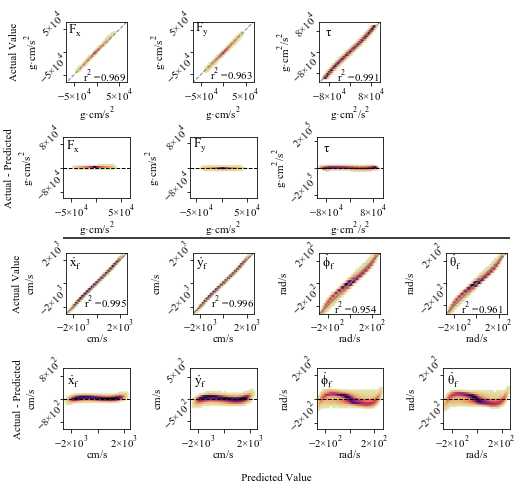

In [376]:
# make plots
from sklearn.metrics import r2_score
from matplotlib import ticker
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.default'] = 'regular'
import matplotlib.ticker as mtick
plt.rcParams.update({'font.size': 11})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.transforms as mtrans


fig_col_names = [r'$F_x$', r'$F_y$', r'$\tau$', r'$\dot{x}_f$', r'$\dot{y}_f$', r'$\dot{\phi}_f$', r'$\dot{\theta}_f$']

plt.close("all")
fig, axs = plt.subplots(4,4, figsize=np.array([8, 7.5]), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = 0.9, wspace=.9)
# fig.suptitle('Predicted vs. acutal ', fontsize=14, fontweight='bold')

axs = axs.ravel("C")

ylabs = [r'$g·cm/s^2$', "$g·cm/s^2$", "$g·cm^2/s^2$", "$cm/s$", "$cm/s$", "$rad/s$", "$rad/s$"]

# replace lightest colors with white
import matplotlib.colors

cmap = plt.cm.magma_r
cmaplist = np.array([cmap(i) for i in range(cmap.N)])
cmaplist[:,0:3] = np.divide(cmaplist[:, 0:3], 1.1)
# make really low-value hexbins white
cmaplist[0] = (1,1,1,0.5)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

# Plot y = actual, x = predicted
for ii in np.arange(0, 3):
    axs[ii].hexbin(y = df_c.loc[:,YtestDF.columns[ii]],
                   x = df_c.loc[:,YpredDF.columns[ii]], 
                   gridsize = 50, cmap = cmap)
    axs[ii].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[ii].set_yticklabels(axs[ii].get_yticklabels(), 
                            rotation = 45, ha="center",
                            va = "bottom", rotation_mode="anchor")
    axs[ii].yaxis.set_label_coords(-0.4,0.5)
    axs[ii].set_xlabel(ylabs[ii] + "\n")
    axs[ii].xaxis.set_label_coords(0.5,-0.3)
    axs[ii].tick_params(axis="x",direction="out", pad=-0)
    

    if(ii == 0):
        axs[ii].set_ylabel("Actual Value\n" + ylabs[ii])
    else:
        axs[ii].set_ylabel(ylabs[ii])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[ii].set_title(fig_col_names[ii], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[ii].title
    ttl.set_position([.15, 0.62])
    
    # draw identity lines
    lims = [
        np.min([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # min of both axes
        np.max([axs[ii].get_xlim(), axs[ii].get_ylim()]),  # max of both axes
        ]
    axs[ii].plot(lims, lims,  
                 'grey', linewidth = 1, linestyle  = "--")
#     axs[ii].plot(df_c.loc[:,YtestDF.columns[ii]], 
#                  df_c.loc[:,YtestDF.columns[ii]], 
#                  'grey', linewidth = 1, linestyle  = "--")
    axs[ii].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[ii].set_aspect('equal', 'box')

    # annotate with R^2
    axs[ii].text(np.max(lims)*-0.4, 
                 np.min(lims)*0.9, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[ii]],  
                                        df_c.loc[:,YpredDF.columns[ii]])), 3)))
    axs[ii].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])
    axs[ii].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[ii]]))])

# # residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
for jj, plotNum in enumerate(np.arange(4, 7)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.3)
    
    if jj == 3:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                      Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 0):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])
        
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.62])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
#####
#### Part 2
#####

#fig.subplots_adjust(hspace = 0.9, wspace=.9)

# Plot y = actual, x = predicted
for plotnum, dataColNum in zip(np.arange(8,12), np.arange(3, 7)):
    axs[plotnum].hexbin(y = df_c.loc[:,YtestDF.columns[dataColNum]],
                   x = df_c.loc[:,YpredDF.columns[dataColNum]], 
                   gridsize = 50, cmap = cmap)
    axs[plotnum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].yaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotnum].set_yticklabels(axs[plotnum].get_yticklabels(),
                                 rotation = 45, ha="center",
                                 va = "bottom", rotation_mode="anchor")
    axs[plotnum].yaxis.set_label_coords(-0.5,0.5)
    axs[plotnum].set_xlabel(ylabs[dataColNum] + "\n")
    axs[plotnum].xaxis.set_label_coords(0.5,-0.3)

    if(plotnum == 8):
        axs[plotnum].set_ylabel("Actual Value\n" + ylabs[dataColNum])
    else:
        axs[plotnum].set_ylabel(ylabs[dataColNum])

    #axs[ii].set_title(YtestDF.columns[ii])
    axs[plotnum].set_title(fig_col_names[dataColNum], 
                           fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotnum].title
    ttl.set_position([.15, 0.60])
    axs[plotnum].plot(df_c.loc[:,YtestDF.columns[dataColNum]], 
                 df_c.loc[:,YtestDF.columns[dataColNum]], 
                 'grey', linewidth = 1, linestyle  = "--")
    axs[plotnum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotnum].set_aspect('equal', 'box')

    # annotate with R^2
    axs[plotnum].text(np.max(df_c.loc[:,YtestDF.columns[dataColNum]])*-0.4, 
                 np.min(df_c.loc[:,YtestDF.columns[dataColNum]])*0.75, 
                 r'$r^2$ =' + 
                 str(np.round((r2_score(df_c.loc[:,YtestDF.columns[dataColNum]],  
                                        df_c.loc[:,YpredDF.columns[dataColNum]])), 3)))
    axs[plotnum].set_xlim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                      np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    axs[plotnum].set_ylim([-np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]])), 
                  np.max(np.abs(df_c.loc[:,YpredDF.columns[dataColNum]]))])
    
    axs[plotnum].tick_params(axis="x",direction="out", pad=-0)

# residual plots x = predicted, y = actual - predicted
# jj is column in dataset, plotNum is plot position
# refref Here
for jj, plotNum in zip(np.arange(3, 7), np.arange(12, 16)):

    axs[plotNum].hexbin(y = df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]],
                   x = df_c.loc[:,YpredDF.columns[jj]], 
                   gridsize = 50, cmap = cmap) 
    axs[plotNum].xaxis.set_major_locator(ticker.MaxNLocator(3))
    axs[plotNum].yaxis.set_major_locator(ticker.MaxNLocator(3))  
    axs[plotNum].set_yticklabels(axs[plotNum].get_yticklabels(), 
                                 rotation = 45, ha="center", 
                                 va = "bottom", rotation_mode="anchor")
    axs[plotNum].yaxis.set_label_coords(-0.4,0.5)
    axs[plotNum].xaxis.set_label_coords(0.5,-0.3)############################
    
    if jj == 4:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n\n" + "                                       Predicted Value")
    else:
        axs[plotNum].set_xlabel(ylabs[jj] + "\n")
    axs[plotNum].yaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))
    axs[plotNum].xaxis.set_major_formatter(MathTextSciFormatter("%1.0e"))

    if(jj == 3):
        axs[plotNum].set_ylabel("Actual - Predicted\n" + ylabs[jj])
    else:
        axs[plotNum].set_ylabel(ylabs[jj])

    axs[plotNum].hlines(y = 0, xmin = np.min( df_c.loc[:,YpredDF.columns[jj]]), 
                   xmax = np.max( df_c.loc[:,YpredDF.columns[jj]]), 
                   linestyle =  "--", linewidth = 1)
    axs[plotNum].set_ylim([-np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]] - df_c.loc[:,YpredDF.columns[jj]])), 
                      np.max(np.abs(df_c.loc[:,YtestDF.columns[jj]]- df_c.loc[:,YpredDF.columns[jj]]))])
    
    axs[plotNum].set_title(fig_col_names[jj], fontdict = {'verticalalignment': 'bottom'})
    ttl = axs[plotNum].title
    ttl.set_position([.15, 0.55])
    axs[plotNum].tick_params(axis="x",direction="out", pad=-0)
    
axs[3].axis('off')
axs[7].axis('off')

# add black horizontal line
ax3 = plt.figure(1).add_subplot(111)
ax3.plot([-1,1],[0.47,0.47], '-', color = "black" )
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.axis("off")

#plt.tight_layout()
fig.savefig(os.path.join(figDir, "PredVActual" + modelName + "PRUNED.pdf"),)
plt.show()
# plt.close()

In [377]:
np.max(df_c.loc[:,"Fy"] - df_c.loc[:,"Fy_pred"])

89981.39214105174

In [378]:
np.max( df_c.loc[:,"Fy_pred"])

68087.14

In [379]:
np.max( df_c.loc[:,"Fy"])

44299.234220458886